## Training the model, setting-up the dataloader 

- Understanding how to setup a basic training pipeline of pytorch using the example of image classification
- Implementing different data augmentation techniques to improve image classification accuracy

## Imports

This will setup your whole environment such that you can work with the rest of the notebook.

### General Imports

In [1]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn                           # helpful for defining the network architecture
import torch.optim as optim                     # helpful for setting up the optimizer
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ModuleNotFoundError: No module named 'torch'

## Set up directory paths and (optionally) mount in Google Colab
If you work with google colab set the `USING_COLAB` variable to `True` and following cell to mount your gdrive.

In [17]:
USING_COLAB = False
USE_CPU = True
# Use the following lines if you want to use Google Colab
# We presume you created a folder "cv3dst" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_03) is given.

if USING_COLAB:
    from google.colab import drive
    import os

    gdrive_path='/content/gdrive/MyDrive/cv3dst/exercise_00'

    # This will mount your google drive under 'MyDrive'
    drive.mount('/content/gdrive', force_remount=True)
    # In order to access the files in this notebook we have to navigate to the correct folder
    os.chdir(gdrive_path)
    # Check manually if all files are present
    print(sorted(os.listdir()))
    root_dir = Path(gdrive_path).parent
else:
    # depending on your folder structure, you might need to adapt this
    root_dir = Path('./cv3dst/')
dataset_dir = root_dir.joinpath("datasets")
output_dir = root_dir.joinpath('exercise_00', 'models')
output_dir.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda') if torch.cuda.is_available() and not USE_CPU else torch.device('cpu')


In [23]:
print(root_dir, dataset_dir)

cv3dst cv3dst/datasets


### Exercise Specific Imports

In [18]:
from exercise_code import train, Net

%load_ext autoreload
%autoreload 2
%matplotlib inline

### 3.1 Setting up the `Dataset` and `DataLoader`



### 3.1.1 Torchvision

Specifically for computer vision, the `torchvision` packages has data loaders for many common datasets such
as ImageNet, FashionMNIST, MNIST and additional data transformers for images in `torchvision.datasets` and `torch.utils.data.DataLoader` modules.

This is highly convenient and is useful in avoiding  to write boilerplate code.

Let's try loading the [`Fashion-MNIST`](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) dataset. It has  gray-scale images of size $28* 28$ belonging to 10 different classes of clothing accessories such as T-Shirt, Trousers, Sneakers.

`transforms.Compose` creates a series of transformation to prepare the dataset.
- `transforms.ToTensor` convert `PIL image` or numpy.ndarray $(H \times W\times C)$ in the range [0,255] to a `torch.FloatTensor` of shape $(C \times H \times W)$ in the range [0.0, 1.0].

- `transforms.Normalize` normalize a tensor image with the provided mean and standard deviation.

In [19]:
# Mean and standard deviations have to be sequences (e.g. tuples),hence we add a comma after the values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))]) 

`datasets.FashionMNIST` downloads the Fashion MNIST dataset and transforms it using our previous cell definition.  
By setting the value of `train`, we get the training and test set.

In [20]:
fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root='../datasets', train=True,
                                                          download=True, transform=transform)
fashion_mnist_test_dataset = torchvision.datasets.FashionMNIST(root='../datasets', train=False,
                                                          download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:03<00:00, 8542104.05it/s]


Extracting ../datasets/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2179640.86it/s]

Extracting ../datasets/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 8062761.09it/s]


Extracting ../datasets/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12116878.22it/s]


Extracting ../datasets/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/FashionMNIST/raw



### 3.1.2 Setting up the `DataLoader`


 `torch.utils.data.Dataloader` takes our training data or test data with parameter
`batch_size` and `shuffle`. The variable `batch_size` defines how many samples per batch to load. The variable `shuffle=True` makes the data reshuffled at every epoch.

In [24]:
fashion_mnist_dataloader = DataLoader(fashion_mnist_dataset, batch_size=8)
fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test_dataset, batch_size=8)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

Let's look at the first batch of data from the `fashion_mnist_dataloader`.

In [25]:
# We can use the exact same way to iterate over samples
for i, item in enumerate(fashion_mnist_dataloader):
    print('Batch {}'.format(i))
    image, label = item
    print(f"Datatype of Image: {type(image)}")
    print(f"Shape of the Image: {image.shape}")
    print(f"Label Values: {label}")

    if i+1 >= 1:
        break

Batch 0
Datatype of Image: <class 'torch.Tensor'>
Shape of the Image: torch.Size([8, 1, 28, 28])
Label Values: tensor([9, 0, 0, 3, 0, 2, 7, 2])


Since we loaded the data with `batch_size` 8, the shape of the input is (8, 1, 28, 28). 

Let's look at  some of the training images.

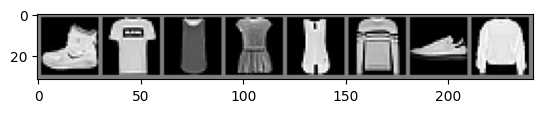

Ankle boot T-shirt/top T-shirt/top Dress T-shirt/top Pullover Sneaker Pullover


In [26]:
def imshow(img):
    img = img / 2 + 0.5 # unormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(fashion_mnist_dataloader)
images, labels = next(dataiter)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

### 3.2 Defining the Neural Network 

PyTorch provides a `nn.Module` that builds neural networks. Now, we will use it to define our network class. We define the network used in this task in <code>exercise_code/data/network</code> in the <code>Net</code> class.

Looking at the constructor of `Net`, we have,
 - `super().__init__` creates a class that inherits attributes and behaviors from another class.

 - `self.fc1` creates an affine layer with `input_size` inputs and `hidden_size` outputs.

 - `self.fc2` is the second affine layer.

The `Forward` function defines the forward pass of the mode.:

 - Input `x` is flattened with `x = x.view(-1, self.input_size)` to be able to use as input to the affine layer.

 - Apply `fc1`, `activation`, `fc2` sequentially to complete the network.
    

Central to all neural networks in PyTorch is the [`autograd`](https://pytorch.org/docs/stable/autograd.html) package. It provides automatic differentiation for all operations on Tensors. 
If we set the attribute `.requires_grad` of `torch.Tensor` as `True`, it tracks all operations applied on that tensor. Once all the computations are finished, the function `.backward()` computes the gradients into the `Tensor.grad` variable

<div class="alert alert-block alert-info">
Thanks to the <b>autograd</b> package, we just have to define the <b>forward()</b> function. We can use any of the Tensor operations in the <b>forward()</b>  function.
 The <b>backward()</b> function (where gradients are computed through back-propagation) is automatically defined by PyTorch.
    </div>

We can use `print()` to look at all the defined layers of the network (but it won't show the information of the forward pass).

The learned parameters of a model are returned by `[model_name].parameters()`. We can also access the parameters of different layers by `[model_name].[layer_name].parameters()`.

Let's create an instance of the `Net` model and look at the parameters matrix shape for each of the layers.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net()
# Always remember to move the network to the GPU/CPU depending on device
net = net.to(device) 

print(net)

print("Shapes of the Parameter Matrix:")
for parameter in net.parameters():
        print(parameter.shape)

Net(
  (activation): Sigmoid()
  (softmax): Softmax(dim=None)
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
Shapes of the Parameter Matrix:
torch.Size([100, 784])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


## 3.3 Defining the Loss function and optimizer

Since it is a multi-class classification, we will use the Cross-Entropy loss and optimize it using SGD with momentum. We had implemented SGD with momentum in Exercise 05. Have a look at the implementations in `exercise_code/networks/optimizer.py` and `exercise_code/networks/loss.py`.

The `torch.nn` and `torch.optim` modules include a variety of loss functions and optimizers. We will initialize an instance of them.

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 3.4 Training the network

We have completed setting up the dataloader, loss function as well as the optimizer. We are now all set for training the network.




<div class="alert alert-info">
    <h3>Task: Training a Neural Network</h3>
    <p> These <b>ice-blue</b> cells mark tasks that you need to complete in order to pass an assignment. To clearly seperate these tasks and to not overfill the notebooks, the tasks are all located in python files under <code>exercise_code/data</code>. For this task, you will find the code you should complete under <a href="../exercise_00/exercise_code/data/train.py"><code>exercise_code/data/train.py</code></a></p>
</div>

<div class="alert alert-danger">
    <h3>Test: Training a Neural Network</h3>
    <p> In most cases, we try to provide some simple test cases for you to check your implementation. These are marked in <b>pink</b> and act as a guideline. Passing these tests does not guarantee passing the assingments. If you do not succed in passing a test, this should give you a hint on the possible location of problems. In this case, there is no test for your implementation.</p>
</div>

In [39]:
max_epochs = 1
train_loss_history, train_acc_history = train(net, fashion_mnist_dataloader, optimizer, criterion, max_epochs, device)

NameError: name 'net' is not defined

So the general training pass is summarized below:

- `zero_grad()`: Zero the gradient buffers of all the model parameters to start the current minibatch iteration.

- `y_pred = net(X)`: Make a forward pass through the network by passing the images to the model to get the predictions, which are log probabilities of image belonging to each of the class.

- `loss = criterion(y_pred, y)`: Calculate the loss from the generated predictions and the training data `y`.

- `loss.backward()`: Perform a backward pass through the network to calculate the gradients for model parameters.

- `optimizer.step()`: Do an optimization step to update the model parameters using the calculated gradients.

We keep tracking the training loss and accuracy over time. The following plot shows average values for train loss and accuracy.

In [ ]:
plt.plot(train_acc_history)
plt.plot(train_loss_history)
plt.title("FashionMNIST")
plt.xlabel('iteration')
plt.ylabel('acc/loss')
plt.legend(['acc', 'loss'])
plt.show()

## 3.5 Testing the performance of the model

We have trained the network for 2 passes over the entire training dataset. Let's check the model performance using the test data.
We will pass the test data to the model to predict the class label and check it against the ground-truth.


In [ ]:
# obtain one batch of test images
dataiter = iter(fashion_mnist_test_dataloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# get sample outputs
outputs = net(images)
# convert output probabilites to predicted class
_, predicted = torch.max(outputs, 1)

We will visualize the results to display the test images and their labels in the following format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

In [ ]:
# prep images for display
if not isinstance(images, np.ndarray):
    images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25,4))
for idx in range(8):
    ax = fig.add_subplot(2, 8//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(f"{classes[predicted[idx]]} ({classes[labels[idx]]})",
                color="green" if predicted[idx]==labels[idx] else "red")

Let's find which classes of images performed well, and the classes that did not perform well!  
`torch.no_grad()` makes sure that gradients are not calculated for the tensors since we only are performing a forward pass.

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in fashion_mnist_test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %11s: %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

### Saving the model

In [ ]:
torch.save(net.state_dict(), output_dir.joinpath("model.pt"))

In [ ]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise00')

## References

1. [PyTorch Tutorial](https://pytorch.org/tutorials/)

2. [Fashion MNIST dataset training using PyTorch](https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4)


